<a href="https://colab.research.google.com/github/SatenikS/Salary-Estimate-Prediction-for-US-Based-Data-Professionals/blob/main/Salary-Estimate-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salary Estimate Prediction for US-based Data Professionals


In [26]:
# Imports necessary libraries
import numpy as np
import datetime
import pandas as pd
from bs4 import BeautifulSoup
import requests
import itertools
from google.colab import drive
import os
import random
import time
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import re
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pd.options.mode.chained_assignment = None

In [27]:
# Changes directory to my Google Drive folder
drive.mount("/content/drive", force_remount=True)
os.chdir("/content/drive/My Drive/Colab Notebooks/Indeed/")

Mounted at /content/drive


In [28]:
# Checks if a "urls.csv" file exists in the directory
if not os.path.isfile("urls.csv"):
  # Sets the desired job titles, cities and experience levels
  job_title = ["data+scientist", "data+analyst"]
  city_and_state = ["San+Francisco,%20CA", "New+York,%20NY", "Chicago,%20IL", "Seattle,%20WA", "Austin,%20TX"]
  experience_level = ["entry_level", "mid_level", "senior_level"]
  # Creates a list of values from 40,000 till 300,000 with 5000 increments
  salary = list(range(40000, 300000, 5000))
  # Creates a DataFrame with all combinations of the above-mentioned values
  urls = pd.DataFrame(itertools.product(job_title,city_and_state, experience_level, salary), 
                      columns = ["job_title", "city_and_state", "experience_level", "salary"])
  # Generates the search URL for each row, specifying a 0 mile radius and Full Time type 
  urls["url"] = "https://www.indeed.com/jobs?q=" + urls["job_title"] + "+$" + urls["salary"].astype(str) + "&l=" + urls["city_and_state"] + \
                "&radius=0&jt=fulltime&explvl=" + urls["experience_level"] + "&filter=0"
  # Creates empty columns to store the timestamp of when the results have been retrieved, ids, and their count
  urls["ts"] = " "
  urls["ids"] = " "
  urls["count"] = np.nan
  # Saves the DataFrame to a csv file
  urls.to_csv("urls.csv", index=False)
  print("Saved dataframe to urls.csv")

In [29]:
def get_page(url, slp):
  """Downloads the page using BeautifulSoup, sleeping at a random interval and testing for CAPTCHAs

        Args:
            url (str): URL of the page
            slp (float): Seconds to sleep before downloading a page

        Returns:
            BeautifulSoup object: Downloaded page
  """
  # Sleeps for the given number of seconds multiplied by a random value from 0 to 1
  time.sleep(slp*random.random())
  while True:
    # Tries to download the page from the given URL, asserts that it's not a CAPTCHA page
    try:
      page = requests.get(url) 
      soup = BeautifulSoup(page.text, "html.parser")
      assert "captcha" not in soup.find("title").text.lower()
    # If CAPTCHA is encountered sleeps for 30 seconds
    except:
      print("CAPTCHA encountered")
      time.sleep(30)
    else:
      return soup 

In [30]:
# Loads the "urls.csv" file, which contains the URLs for every search query of interest
urls = pd.read_csv("urls.csv")
# If any cell in the ts (timestamp) column is empty
while (urls["ts"] == " ").any():
  # Gets the index of the first row where the cell in the ts (timestamp) column is empty
  query_id = urls.index[(urls["ts"] == " ")][0]
  # Retrieves the url for the query
  url = urls["url"].at[query_id]
  # Modifies the url to return the first search result page
  url_first_page = url + "&start=0"
  # Downloads the page
  soup = get_page(url_first_page, 3)
  # Tries to get the number of pages from the search results, if unsuccessful then only one page exists
  try:
    num_listings = int(soup.find_all("div", id="searchCountPages")[0].text.split(" ")[-2])
  except:
    num_listings = 1
  # Creates a list of page start indices with increments of 10, e.g. if there are 34 listings, then [0, 10, 20, 30]
  page_starts = [x*10 for x in range(0, num_listings//10 + 1)]
  # Creates an empty list to store all listing ids
  all_ids = []
  # For each search result page
  for start in page_starts:
    # Modifies the url to return the desired search result page
    curr_url = url + "&start=" + str(start)
    # Downloads the page
    soup = get_page(curr_url, 0.5)
    # Finds all buttons of the given class
    buttons = soup.find_all("button", class_ = "job-reaction-kebab-item job-reaction-report")
    # Extracts job ids from the attributes
    job_ids = [x["onclick"].split("'")[1] for x in buttons]
    # Adds the ids to the list
    all_ids.extend(job_ids)
  # Removes duplicates from the list of ids
  all_ids = list(set(all_ids))
  # Joins all ids in a string with "|" deliminator and adds to the DataFrame
  urls.at[query_id, "ids"] = "|".join(all_ids)
  # Saves the timestamp and number of ids
  urls.at[query_id, "ts"] = str(datetime.datetime.utcnow())
  urls.at[query_id, "count"] = len(all_ids)
  # Saves the dataframe to a csv file
  urls.to_csv("urls.csv", index=False)

In [31]:
# Checks if a "listings.csv" file exists in the directory
if not os.path.isfile("listings.csv"):
  # Loads the "urls.csv" file, which contains the URLs for every search query of interest
  listings = pd.read_csv("urls.csv")
  # Removes all rows where count is 0
  listings = listings[listings["count"] > 0]
  # Drops the ts (timestamp) and count columns
  listings.drop(columns=['ts','count'], inplace=True)
  # 'Explodes' the DataFrame, by creating a separate row for each id from the list of ids in each row
  listings = listings.assign(ids=listings['ids'].str.split("|")).explode('ids').reset_index(drop=True)
  # Finds the salary for each listing by knowing at which salary filter value which job listing stopped appearing
  listings = listings.groupby(["job_title", "city_and_state", "experience_level", "ids"])["salary"].max().reset_index()
  # Changes the job_title and city_and_state to be more readable
  listings["job_title"] = listings["job_title"].str.replace("+", "_")
  listings["city_and_state"] = listings["city_and_state"].str.replace(",%20", "_").str.replace("+", "_").str.lower()
  # Renames the column ids to id, since it now contains only one id per row after 'Exploding'
  listings.rename(columns={"ids": "id"}, inplace=True)
  # Generates the job listing URL for each row
  listings["listing_url"] = "https://www.indeed.com/viewjob?jk=" + listings["id"]
  # Creates empty columns to store the timestamp of when the results have been retrieved and listing information
  listings["ts"] = " "
  listings["listing_title"] = " "
  listings["listing_company"] = " "
  listings["listing_description"] = " "
  # Saves the DataFrame to a csv file
  listings.to_csv("listings.csv", index=False)
  print("Saved dataframe to listings.csv")

In [32]:
# Loads the "listings.csv" file, which contains the URLs for every job listing
listings = pd.read_csv("listings.csv")
# If any cell in the ts (timestamp) column is empty
while (listings["ts"] == " ").any():
  # Gets the index of the first row where the cell in the ts (timestamp) column is empty
  listing_id = listings.index[(listings["ts"] == " ")][0]
  # Retrieves the url for the job listing
  url = listings["listing_url"].at[listing_id]
  # Downloads the page
  soup = get_page(url, 0.5)
  # Tries to find the known error messages on the page
  error_messages = soup.find_all(text="The page you requested could not be found.") + soup.find_all(text="Oops! Something is broken...")
  # If any of the error messages are present
  if len(error_messages) > 0:
    # Removes the listing from the DataFrame and saves to a csv
    listings.drop(index=listing_id, inplace=True)
    listings.to_csv("listings.csv", index=False)
  # If no errors are present
  else:
    # Extracts and saves the listing title
    listings.at[listing_id, "listing_title"] = soup.find_all("div", class_="jobsearch-JobInfoHeader-title-container")[0].text
    # Extracts and saves listing company
    listings.at[listing_id, "listing_company"] = soup.find_all("div", class_="icl-u-lg-mr--sm")[0].text
    desc = soup.find_all("div", class_="jobsearch-jobDescriptionText")[0].text
    # Extracts the description, removes all punctuation, makes everything lowercase and saves
    listings.at[listing_id, "listing_description"] = re.sub(r"[^\w\s]", " ", desc.lower())
    # Saves the timestamp
    listings.at[listing_id, "ts"] = str(datetime.datetime.utcnow())
    # Saves the dataframe to a csv file
    listings.to_csv("listings.csv", index=False)

In [33]:
# Loads the "listings.csv" file, which contains the URLs and data for every job listing
listings = pd.read_csv("listings.csv")

In [34]:
# Creates a new DataFrame to store data in a format ready for Machine Learning
df = listings[["id", "salary"]]
# Creates a list of keywords of interest
keywords = ["sql", "python", "tableau", "html", "cloud", "hive", "spark", "hadoop", "looker", "agile", "pandas"]
# Creates a binary column for each keyword, indicating the presence of the keyword in the desctiption
for kwd in keywords:
  df[kwd] = listings["listing_description"].str.contains(kwd, regex=False).astype(int)
# Converts the categorical variables city_and_state and job_title to dummy/indicator variables
df = pd.concat([pd.get_dummies(listings["city_and_state"], prefix="city"), df], axis=1)
df = pd.concat([pd.get_dummies(listings["job_title"], prefix="title"), df], axis=1)
# Converts the categorical variables experience_level to ordinal variable
experience_level_mapper = {"entry_level":0, "mid_level":1, "senior_level":2}
df["experience_level"] = listings["experience_level"].replace(experience_level_mapper)
# Makes id the first column
col = df.pop("id")
df.insert(0, col.name, col)
# Makes salary the last column
col = df.pop("salary")
df.insert(df.shape[1], col.name, col)

In [73]:
# Prints a sample 10 rows from the DataFrame
df.sample(10)

,id,title_data_analyst,title_data_scientist,city_austin_tx,city_chicago_il,city_new_york_ny,city_san_francisco_ca,city_seattle_wa,sql,python,tableau,html,cloud,hive,spark,hadoop,looker,agile,pandas,experience_level,salary
1083,b45da2f75750ba2e,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,80000
1714,b34ab0e352d838c3,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,80000
223,4c52fd70c91b46bc,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,105000
947,c6590a96e5a01815,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,110000
1796,f17cc63405acbbeb,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,115000
1373,60ff883043784fed,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,65000
1989,5a1bff3bff6a65be,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,185000
398,a1029cb2153c7cca,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,125000
1849,6720cf1c03a1c426,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,80000
2619,f4e7f972e29c2d05,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,150000


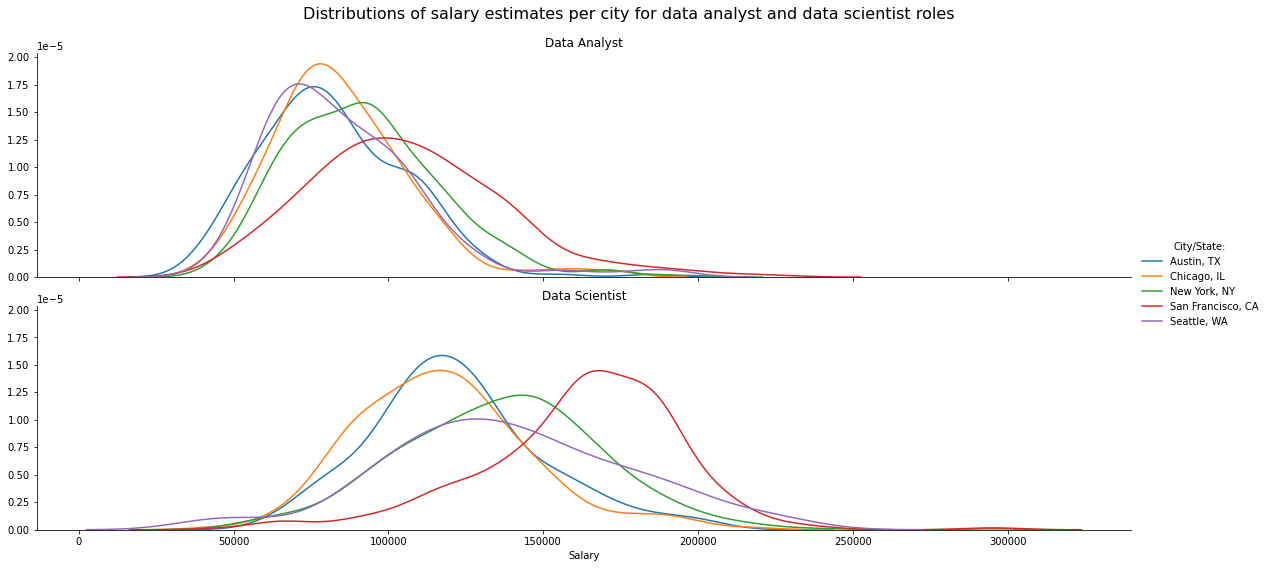

In [74]:
# Shows the distributions of salary estimates per city for data analyst and data scientist roles
g = sns.FacetGrid(listings, row="job_title", hue="city_and_state", height=4, aspect=4)
g.map(sns.kdeplot, "salary")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distributions of salary estimates per city for data analyst and data scientist roles", fontsize=16)
g.add_legend()
g._legend.set_title("City/State:")
plt.xlabel("Salary")
capt = lambda x: x.split("_")[0].capitalize() + " " + x.split("_")[1].capitalize() + ", " + x.split("_")[2].upper() if len(x.split("_")) > 2 else x.split("_")[0].capitalize() + ", " + x.split("_")[1].upper()
for l in g._legend.texts: l.set_text(capt(l.get_text()))
g = g.axes.flatten()
g[0].set_title("Data Analyst")
g[1].set_title("Data Scientist")
g;

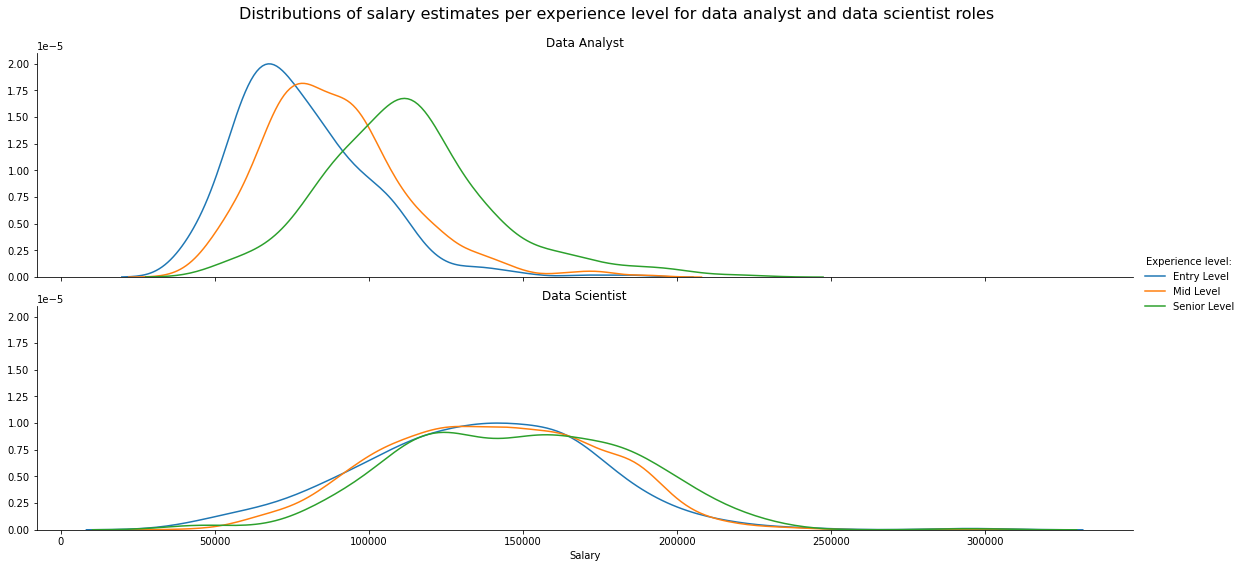

In [75]:
# Shows the distribution of salary estimates for data analysts and data scientists per their experience level
g = sns.FacetGrid(listings, row="job_title", hue="experience_level", height=4, aspect=4)
g.map(sns.kdeplot, "salary")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distributions of salary estimates per experience level for data analyst and data scientist roles", fontsize=16)
g.add_legend()
g._legend.set_title("Experience level:")
plt.xlabel("Salary")
capt = lambda x: x.split("_")[0].capitalize() + " " + x.split("_")[1].capitalize()
for l in g._legend.texts: l.set_text(capt(l.get_text()))
g = g.axes.flatten()
g[0].set_title("Data Analyst")
g[1].set_title("Data Scientist")
g;

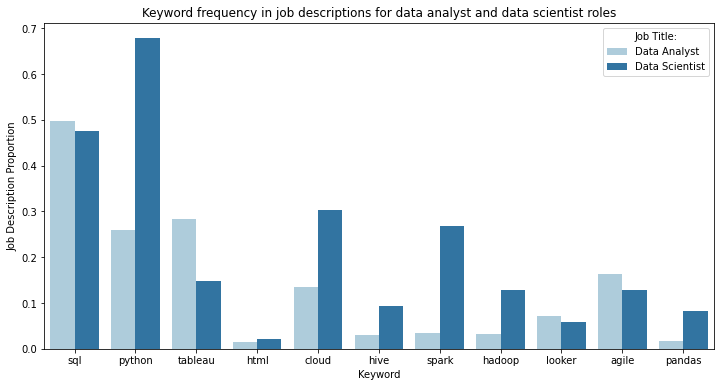

In [77]:
# Plots the keyword frequency in job descriptions for data analyst and data scientist roles
job_title_kwd = pd.concat([listings["job_title"], df[keywords]], axis=1).groupby("job_title").sum().div(listings["job_title"].value_counts(), axis="index").reset_index()
job_title_kwd = pd.melt(job_title_kwd, id_vars=["job_title"], value_vars=keywords, var_name="keyword")
job_title_kwd.rename(columns = {"value": "listing_fraction"}, inplace=True)
plt.figure(figsize=(12, 6))
g = sns.barplot(data=job_title_kwd, x="keyword", y="listing_fraction", hue="job_title", palette="Paired")
plt.title("Keyword frequency in job descriptions for data analyst and data scientist roles", fontsize=12)
h, l = g.get_legend_handles_labels()
g.legend(h, [x.split("_")[0].capitalize() + " " + x.split("_")[1].capitalize() for x in l], title="Job Title:")
plt.xlabel("Keyword")
plt.ylabel("Job Description Proportion")
g;

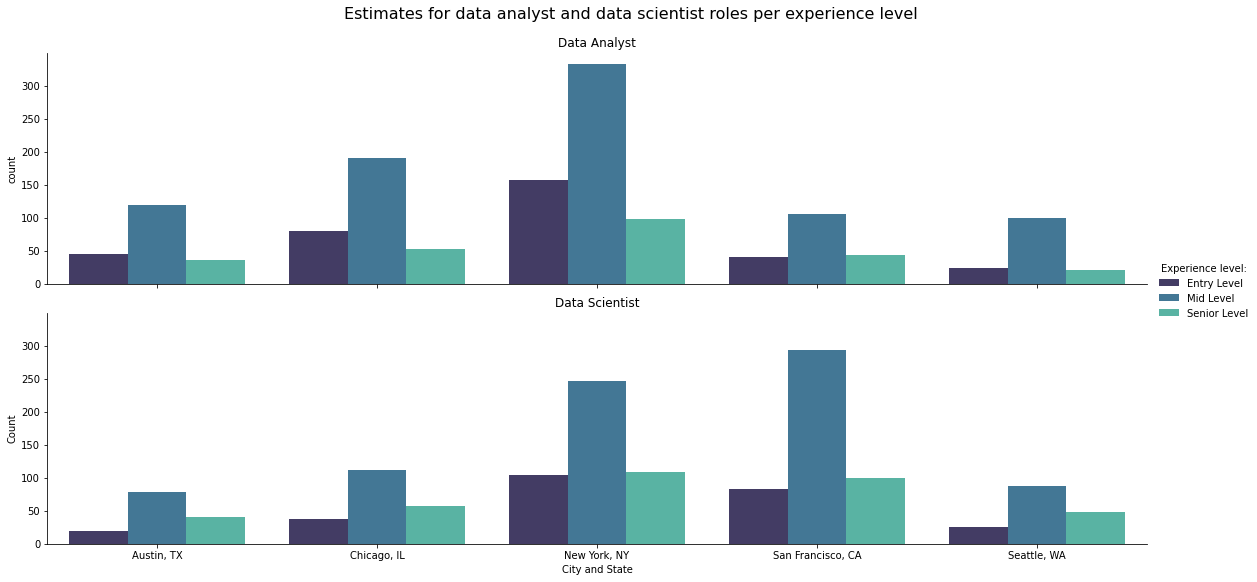

In [78]:
# Plots the estimates for data analyst and data scientist roles per experience level
job_count = listings.groupby(["city_and_state", "experience_level", "job_title"])["id"].count().reset_index()
job_count.rename(columns = {"id":"count"}, inplace=True)
capt = lambda x: x.split("_")[0].capitalize() + " " + x.split("_")[1].capitalize() + ", " + x.split("_")[2].upper() if len(x.split("_")) > 2 else x.split("_")[0].capitalize() + ", " + x.split("_")[1].upper()
job_count["city_and_state"] = job_count["city_and_state"].apply(capt)
g = sns.catplot(x="city_and_state", y="count", hue="experience_level", kind="bar", row="job_title", data=job_count, height=4, aspect=4, palette="mako")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Estimates for data analyst and data scientist roles per experience level", fontsize=16)
plt.xlabel("City and State")
plt.ylabel("Count")
capt = lambda x: x.split("_")[0].capitalize() + " " + x.split("_")[1].capitalize()
for l in g._legend.texts: l.set_text(capt(l.get_text()))
g._legend.set_title("Experience level:")
g = g.axes.flatten()
g[0].set_title("Data Analyst")
g[1].set_title("Data Scientist")
g;

In [79]:
# Creates the X by removing the id column and the target variable (salary)
X = df.iloc[:, 1:-1]
# Creates the Y
y = df.iloc[:, -1]

# Splits X and Y into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Creates a range of values for the Alpha hyperparameter
params = {"alpha": np.arange(0.1, 10, 0.1)}

# Creates a dictionary of models: OLS, Lasso and Ridge
models = {"OLS": linear_model.LinearRegression(),
          "Lasso": GridSearchCV(linear_model.Lasso(tol=0.001, normalize=True), param_grid=params),
          "Ridge": GridSearchCV(linear_model.Ridge(tol=0.001, normalize=True), param_grid=params)}

# Creates an empty DataFrame to save the results
results = pd.DataFrame(columns=["model","best_alpha","MAE_train","MAE_test","MSE_train","MSE_test","R2_train","R2_test"])

# Trains each model and saves performace results
for model in models:
  clf = models[model]
  clf.fit(X_train, y_train)

  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)

  MAE_train = mean_absolute_error(y_train, y_train_pred)
  MAE_test = mean_absolute_error(y_test, y_test_pred)

  MSE_train = mean_squared_error(y_train, y_train_pred)
  MSE_test = mean_squared_error(y_test, y_test_pred)

  R2_train = r2_score(y_train, y_train_pred)
  R2_test = r2_score(y_test, y_test_pred)

  alpha = clf.best_params_["alpha"] if model != "OLS" else "n/a"

  dict = {"model": model,
          "best_alpha": alpha,
          "MAE_train": MAE_train, "MAE_test": MAE_test,
          "MSE_train": MSE_train, "MSE_test": MSE_test,
          "R2_train": R2_train, "R2_test": R2_test}

  results = results.append(dict, ignore_index=True)

results

,model,best_alpha,MAE_train,MAE_test,MSE_train,MSE_test,R2_train,R2_test
0,OLS,n/a,20990.290189,20980.740331,7.547894e+08,7.364040e+08,0.543989,0.540526
1,Lasso,4.3,21003.966410,20993.226695,7.552048e+08,7.373827e+08,0.543738,0.539916
2,Ridge,0.1,21064.879180,21079.790073,7.566938e+08,7.390648e+08,0.542839,0.538866


Mean absolute error: 21079.79
Coefficient of determination: 0.54




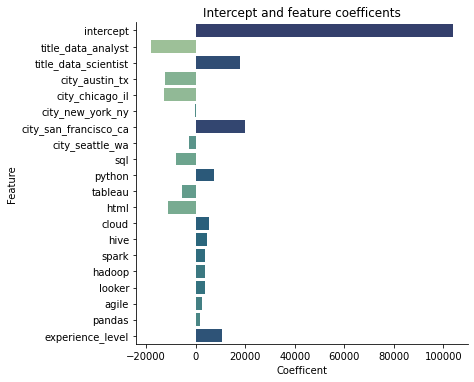

In [80]:
# Creates a Ridge model with the best Alpha hyperparameter value
best_alpha = results.loc[results["model"]=="Ridge", "best_alpha"].iloc[0]
regr = linear_model.Ridge(alpha=best_alpha, normalize=True)

# Trains the model
regr.fit(X_train, y_train)

# Predicts the salary estimate
y_pred = regr.predict(X_test)

# Creates a DataFrame of coefficients
coef = pd.DataFrame({"feature": X.columns, "coefficent": np.round(np.transpose(regr.coef_), 2)})
coef = pd.concat([pd.DataFrame({"feature": "intercept", "coefficent": np.round(regr.intercept_, 2)}, index=[0]), coef])

# Prints the Mean Squared Error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
# Prints the coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plots the intercept and feature coefficents
print("\n")
g = sns.catplot(data=coef, y="feature", x="coefficent", kind="bar", hue="coefficent", dodge=False, orient="h", height=5, aspect=1.3, palette="crest")
plt.xlabel("Coefficent")
plt.ylabel("Feature")
plt.title("Intercept and feature coefficents", fontsize=12)
g;

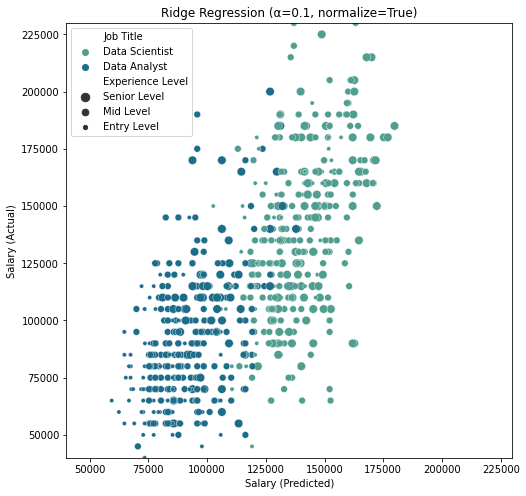

In [81]:
# Plots the actual vs predicted salaries, color and size coded by job title and seniority respectively
sc_plot = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})
sc_plot = sc_plot.merge(listings[["job_title","experience_level"]], left_index=True, right_index=True, how='left')
plt.figure(figsize=(8, 8))
g = sns.scatterplot(data=sc_plot, x="y_pred", y="y_test", hue="job_title", size="experience_level", palette="crest")
min_max = (min(y_pred.tolist() + list(y_test)), max(y_pred.tolist() + list(y_test)))
g.set(xlim=min_max, ylim=min_max)
plt.legend(loc="upper left")
plt.xlabel("Salary (Predicted)")
plt.ylabel("Salary (Actual)")
h, l = g.get_legend_handles_labels()
plt.title("Ridge Regression (α=0.1, normalize=True)", fontsize=12)
g.legend(h, [x.split("_")[0].capitalize() + " " + x.split("_")[1].capitalize() for x in l])
g;